# Text classification of sexist sentences

This notebook explores different machine learning and deep learning SotA models in order to classify sentences from EDOS dataset as sexist or not.

There exist two version of the EDOS dataset:
- The **original** EDOS dataset
- The **balanced** EDOS dataset

For each dataset, we will apply the following techniques and models:
1. **Support Vector Machine** for binary classification of sentence embeddings
2. **Classification Trees** for binary classification of sentence embeddings
3. **Neural Network** for binary sentence classification
4. **Neural Network** for ngrams' embedding classification

Firstly, we will perform some data analysis and exploration along with text preprocessing for training, validation and test data independently.

In [75]:
%pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
%pip install -q numpy pandas matplotlib seaborn scikit-learn nltk spacy
%pip install -q huggingface_hub sentence_transformers accelerate
%pip install -q spacytextblob

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [84]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from numpy import mean
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV 
from sentence_transformers import SentenceTransformer
from spacytextblob.spacytextblob import SpacyTextBlob

In [77]:
# detect device (cuda recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [78]:
# load original (unbalanced) and balanced datasets
original_data = "data/edos_labelled_aggregated.csv"
balanced_data = "hf://datasets/tum-nlp/sexism-socialmedia-balanced/sexism-socialmedia-balanced.csv"

original_df = pd.read_csv(original_data)
balanced_df = pd.read_csv(balanced_data)

In [79]:
# split balanced dataset as it is not already split into train/dev/test
X = balanced_df['text']
y = balanced_df['label_sexist']

X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X, y, test_size=0.20, random_state=1)
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(X_train_bal, y_train_bal, test_size=0.12, random_state=1)

# check the shapes of the datasets
print("Original train shape:", original_df.loc[original_df['split'] == 'train'].shape)
print("Original validation shape:", original_df.loc[original_df['split'] == 'dev'].shape)
print("Original test shape:", original_df.loc[original_df['split'] == 'test'].shape)

print("\nBalanced train shape:", X_train_bal.shape)
print("Balanced validation shape:", X_val_bal.shape)
print("Balanced test shape:", X_test_bal.shape)

Original train shape: (14000, 6)
Original validation shape: (2000, 6)
Original test shape: (4000, 6)

Balanced train shape: (14155,)
Balanced validation shape: (1931,)
Balanced test shape: (4022,)


In [80]:
# save train, val and test sets to csv files for balanced dataset
X_train_bal.to_csv('data/balanced_train.csv', index=False)
X_val_bal.to_csv('data/balanced_val.csv', index=False)
X_test_bal.to_csv('data/balanced_test.csv', index=False)

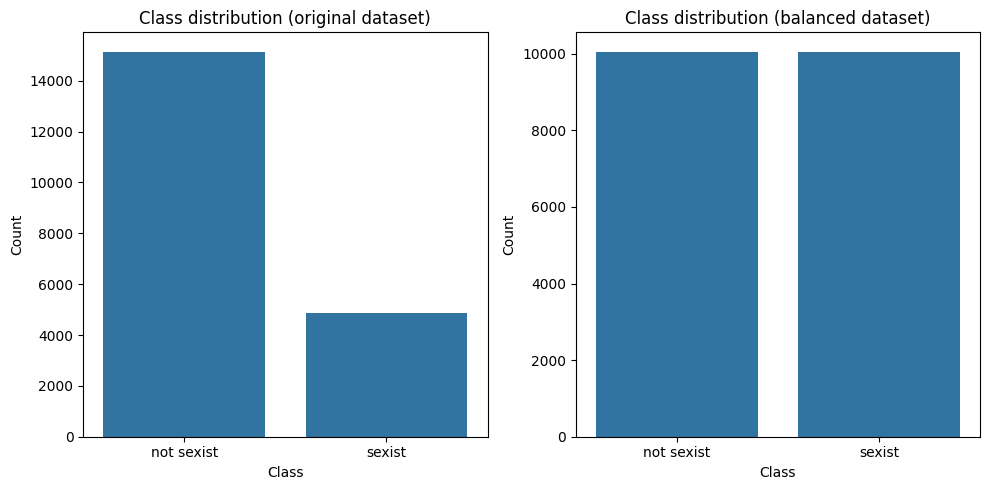

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# plot original dataset sentence distribution
sns.countplot(ax=axes[0], x='label_sexist', data=original_df)
axes[0].set_title('Class distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# plot balanced dataset sentence distribution
sns.countplot(ax=axes[1], x='label_sexist', data=balanced_df)
axes[1].set_title('Class distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Polarity and subjectivity of texts

In [82]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# perform lemmatization and remove stop words and punctuation
def preprocess_text(text):
    doc = nlp(text)
    tokens = [
        token.lemma_.lower() if token.lemma_ != "-PRON-" else token.text.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.text not in ["[USER]", "[URL]"]
    ]
    return " ".join(tokens)

# remove NaN values from both datasets
balanced_df.dropna(subset=['text'], inplace=True)
original_df.dropna(subset=['text'], inplace=True)

# apply preprocessing to both datasets
balanced_df['text'] = balanced_df['text'].apply(preprocess_text)
original_df['text'] = original_df['text'].apply(preprocess_text)

In [85]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

def get_sentiment(text):
    doc = nlp(text)
    polarity = doc._.blob.polarity
    subjectivity = doc._.blob.subjectivity
    return polarity, subjectivity

# get sentiment polarity and subjectivity for both datasets
original_df['polarity'], original_df['subjectivity'] = zip(*original_df['text'].apply(get_sentiment))
balanced_df['polarity'], balanced_df['subjectivity'] = zip(*balanced_df['text'].apply(get_sentiment))

Text(0, 0.5, 'Polarity')

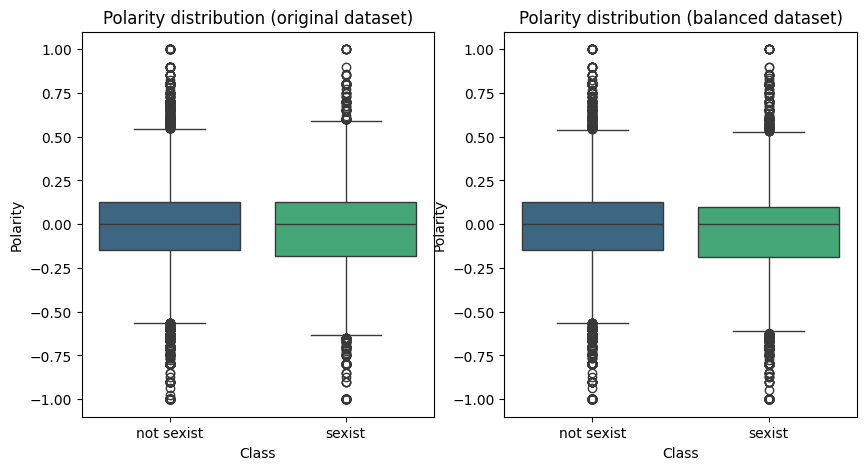

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot original dataset polarity distribution
sns.boxplot(ax=axes[0], y='polarity', x='label_sexist', data=original_df, palette='viridis', hue='label_sexist', legend=False)
axes[0].set_title('Polarity distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Polarity')

# plot balanced dataset polarity distribution
sns.boxplot(ax=axes[1], y='polarity', x='label_sexist', data=balanced_df, palette='viridis', hue='label_sexist', legend=False)
axes[1].set_title('Polarity distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Polarity')

Text(0, 0.5, 'Subjectivity')

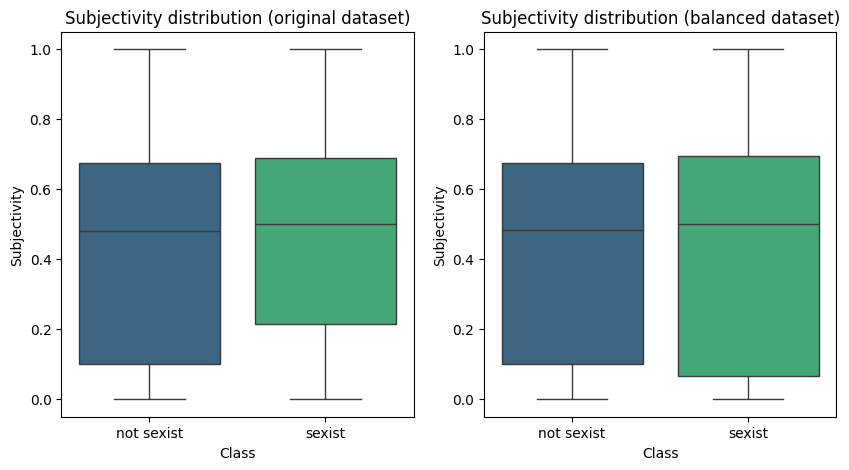

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot original dataset subjectivity distribution
sns.boxplot(ax=axes[0], x='label_sexist', y='subjectivity', data=original_df, palette='viridis', hue='label_sexist', legend=False)
axes[0].set_title('Subjectivity distribution (original dataset)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Subjectivity')

# plot balanced dataset subjectivity distribution
sns.boxplot(ax=axes[1], x='label_sexist', y='subjectivity', data=balanced_df, palette='viridis', hue='label_sexist', legend=False)
axes[1].set_title('Subjectivity distribution (balanced dataset)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Subjectivity')

### Considerations

The original dataset class distribution is very unbalanced with respect to the balanced one.

There is no big difference between sentence polarity of sexist and not sexist sentences, hinting that these sentences are quite similar. We can say the same about the **subjectivity** of the sentences. Polarity and subjectiveness cannot be used to distinguish sexist sentences from not sexist ones.

## Check for linear separability with SVM

SVMs with linear kernel find the longest margin that separates train data. If we set the C hyperparameter to a very high number (e.g. 2^32), we will force the optimizer to make 0 error in classification in order to minimize the loss function. Thus, we will overfit the data. If we can overfit it with a linear model, that means the data is linearly separable. In order to check for linear separability:

1. Instantiate a SVM with a big C hyperparameter
2. Train the model with the data
3. Classify the train set with the trained SVM
4. If we get 100% accuracy on classification, the data is linearly separable

In [88]:
original_sentences = original_df['text'].values
balanced_sentences = balanced_df['text'].values
original_labels = original_df['label_sexist'].values
balanced_labels = balanced_df['label_sexist'].values

# load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# encode the sentences using the SentenceTransformer model
X_original = model.encode(original_sentences)
X_balanced = model.encode(balanced_sentences)

# encode the labels to binary values
y_original = [1 if label=='sexist' else 0 for label in original_df['label_sexist']]
y_balanced = [1 if label=='sexist' else 0 for label in balanced_df['label_sexist']]

In [89]:
# get the train, validation, and test sets from the original dataset
X_train = original_df.loc[original_df['split'] == 'train']['text']
y_train = original_df.loc[original_df['split'] == 'train']['label_sexist']
X_val = original_df.loc[original_df['split'] == 'dev']['text']
y_val = original_df.loc[original_df['split'] == 'dev']['label_sexist']
X_test = original_df.loc[original_df['split'] == 'test']['text']
y_test = original_df.loc[original_df['split'] == 'test']['label_sexist']

model = SentenceTransformer("all-MiniLM-L6-v2")

train_sentences = X_train.values
train_sentences_bal = X_train_bal.values
val_sentences = X_val.values
val_sentences_bal = X_val_bal.values
test_sentences = X_test.values
test_sentences_bal = X_test_bal.values

# encode the sentences using the SentenceTransformer model
X_train_embeddings = model.encode(train_sentences)
X_train_embeddings_bal = model.encode(train_sentences_bal)
X_val_embeddings = model.encode(val_sentences)
X_val_embeddings_bal = model.encode(val_sentences_bal)
X_test_embeddings = model.encode(test_sentences)
X_test_embeddings_bal = model.encode(test_sentences_bal)

# encode the labels to binary values
y_train_labels = [1 if label=='sexist' else 0 for label in y_train]
y_train_labels_bal = [1 if label=='sexist' else 0 for label in y_train_bal]
y_val_labels = [1 if label=='sexist' else 0 for label in y_val]
y_val_labels_bal = [1 if label=='sexist' else 0 for label in y_val_bal]
y_test_labels = [1 if label=='sexist' else 0 for label in y_test]
y_test_labels_bal = [1 if label=='sexist' else 0 for label in y_test_bal]

In [90]:
# check if original data is linearly separable with SVM technique
clf = svm.SVC(C=2**32)
clf.fit(X_train_embeddings, y_train_labels)

y_pred = clf.predict(X_train_embeddings)
print(confusion_matrix(y_train_labels, y_pred))

# check if balanced data is linearly separable with SVM technique
clf_bal = svm.SVC(C=2**32)
clf_bal.fit(X_train_embeddings_bal, y_train_labels_bal)

y_pred = clf_bal.predict(X_train_embeddings_bal)
print(confusion_matrix(y_train_labels_bal, y_pred))

[[10091   511]
 [  922  2476]]
[[7035    0]
 [   0 7120]]


### Considerations

The original dataset shows **non-linear separable data** while the balanced one shows **linear separable data**. These results are achieved overfitting a SVM on both datasets.

From now on, we will use **non-linear classifiers** on the original dataset and **linear classifiers** on the balanced one.

## Using K-fold cross-validation to choose the best model to train
In order to choose what model to train, it is better to perform a k-fold cross-validation on the training set for the selected models. The one with the higher ROC AUC mean value will be chosen as the best model and then trained.

In [92]:
# SVM, logistic regression, and perceptron classifiers
clf = svm.SVC()
lr = LogisticRegression()
pr = Perceptron()

# evaluate model computing roc_auc score using cross-validation
svm_scores = cross_val_score(clf, X_train_embeddings_bal, y_train_labels_bal, scoring='accuracy', cv=10)
lr_scores = cross_val_score(lr, X_train_embeddings_bal, y_train_labels_bal, scoring='accuracy', cv=10)
pr_scores = cross_val_score(pr, X_train_embeddings_bal, y_train_labels_bal, scoring='accuracy', cv=10)

# summarize performances
print('Mean accuracy for SVM: %.2f with a standard deviation of %.2f' % (mean(svm_scores), svm_scores.std()))
print('\nMean accuracy for logistic regression: %.2f with a standard deviation of %.2f' % (mean(lr_scores), lr_scores.std()))
print('\nMean accuracy for perceptron: %.2f with a standard deviation of %0.2f' % (mean(pr_scores), pr_scores.std()))

Mean accuracy for SVM: 0.81 with a standard deviation of 0.01

Mean accuracy for logistic regression: 0.78 with a standard deviation of 0.01

Mean accuracy for perceptron: 0.71 with a standard deviation of 0.03


## 1. Support Vector Machine for classification

We have found out that the original dataset shows non-linear data while the balanced one is supposed to be linearly separable. We will now train two Support Vector Machines (SVMs) with different kernels:
1. A SVM with a **non-linear kernel** for the original dataset
2. A SVM with a **linear kernel** for the balances dataset

We will perform a randomized search with cross-validation choosing the parameters that maximizes the accuracy of both models. We will not focus on the recall or the f-beta score as we are not interested in higher values of recall because the nature of english language is able to mask intentions with different words that will never be caught entirely by a model.

In [93]:
# note: this operation will take approx. 20 minutes
param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid'],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:5}]
}

random_search = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_distributions,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=3,
    random_state=42
)

# fitting the model for randomized search
random_search.fit(X_train_embeddings, y_train_labels)
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END C=100, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.665 total time=  11.2s
[CV 2/3] END C=100, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.675 total time=  10.2s
[CV 3/3] END C=100, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.678 total time=  10.8s
[CV 1/3] END C=1, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.745 total time=  13.4s
[CV 2/3] END C=1, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.749 total time=  16.8s
[CV 3/3] END C=1, class_weight={0: 1, 1: 2}, kernel=sigmoid;, score=0.751 total time=  16.4s
[CV 1/3] END C=10, class_weight={0: 1, 1: 5}, kernel=sigmoid;, score=0.575 total time=  14.7s
[CV 2/3] END C=10, class_weight={0: 1, 1: 5}, kernel=sigmoid;, score=0.559 total time=  14.2s
[CV 3/3] END C=10, class_weight={0: 1, 1: 5}, kernel=sigmoid;, score=0.564 total time=  13.5s
[CV 1/3] END C=1, class_weight={0: 1, 1: 5}, kernel=sigmoid;, score=0.607 total time=  19.5s


In [94]:
# note: this operation will take approx. 20 minutes
param_grid_bal = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'kernel': ['linear'],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:5}]
}

random_search_bal = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_grid_bal,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=3,
    random_state=42
)
  
# fitting the model for randomized search
random_search_bal.fit(X_train_embeddings_bal, y_train_labels_bal)
print("Best Parameters:", random_search_bal.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END C=0.01, class_weight=balanced, kernel=linear;, score=0.745 total time=  24.3s
[CV 2/3] END C=0.01, class_weight=balanced, kernel=linear;, score=0.769 total time=  26.6s
[CV 3/3] END C=0.01, class_weight=balanced, kernel=linear;, score=0.757 total time=  26.4s
[CV 1/3] END C=0.01, class_weight={0: 1, 1: 2}, kernel=linear;, score=0.565 total time=  23.5s
[CV 2/3] END C=0.01, class_weight={0: 1, 1: 2}, kernel=linear;, score=0.547 total time=  22.1s
[CV 3/3] END C=0.01, class_weight={0: 1, 1: 2}, kernel=linear;, score=0.564 total time=  22.1s
[CV 1/3] END C=0.01, class_weight={0: 1, 1: 5}, kernel=linear;, score=0.503 total time=  19.8s
[CV 2/3] END C=0.01, class_weight={0: 1, 1: 5}, kernel=linear;, score=0.503 total time=  19.9s
[CV 3/3] END C=0.01, class_weight={0: 1, 1: 5}, kernel=linear;, score=0.503 total time=  18.9s
[CV 1/3] END C=0.1, class_weight=balanced, kernel=linear;, score=0.774 total time=  17.9s
[CV 2/

In [95]:
# SVM with non-linear kernel trained on the original dataset
clf = random_search.best_estimator_
clf.fit(X_train_embeddings, y_train_labels)

y_test_pred = clf.predict(X_test_embeddings)

tn, fp, fn, tp = confusion_matrix(y_test_labels, y_test_pred).ravel()
print("SVM trained on the original dataset")
print("\nTrue positive:", tp, "\tFalse positive:", fp, "\nFalse negative:", fn, "\tTrue negative:", tn)

# generate the classification report
print("\nClassification Report:")
clf_report = classification_report(y_test_labels, y_test_pred, target_names=['Not Sexist', 'Sexist'], output_dict=True)
print(clf_report)

SVM trained on the original dataset

True positive: 461 	False positive: 274 
False negative: 509 	True negative: 2756

Classification Report:
{'Not Sexist': {'precision': 0.844104134762634, 'recall': 0.9095709570957096, 'f1-score': 0.8756155679110406, 'support': 3030.0}, 'Sexist': {'precision': 0.6272108843537415, 'recall': 0.47525773195876286, 'f1-score': 0.5407624633431085, 'support': 970.0}, 'accuracy': 0.80425, 'macro avg': {'precision': 0.7356575095581878, 'recall': 0.6924143445272362, 'f1-score': 0.7081890156270745, 'support': 4000.0}, 'weighted avg': {'precision': 0.7915075215384776, 'recall': 0.80425, 'f1-score': 0.7944136900533171, 'support': 4000.0}}


In [96]:
# SMV with linear kernel trained on the balanced dataset
clf_bal = random_search_bal.best_estimator_
clf_bal.fit(X_train_embeddings_bal, y_train_labels_bal)

y_test_pred_bal = clf_bal.predict(X_test_embeddings_bal)

tn, fp, fn, tp = confusion_matrix(y_test_labels_bal, y_test_pred_bal).ravel()
print("SVM trained on the balanced dataset")
print("\nTrue positive:", tp, "\tFalse positive:", fp, "\nFalse negative:", fn, "\tTrue negative:", tn)

# generate the classification report
print("\nClassification Report:")
clf_bal_report = classification_report(y_test_labels_bal, y_test_pred_bal, target_names=['Not Sexist', 'Sexist'], output_dict=True)
print(clf_bal_report)

SVM trained on the balanced dataset

True positive: 1506 	False positive: 431 
False negative: 463 	True negative: 1622

Classification Report:
{'Not Sexist': {'precision': 0.777937649880096, 'recall': 0.7900633219678519, 'f1-score': 0.7839536007733204, 'support': 2053.0}, 'Sexist': {'precision': 0.7774909654104285, 'recall': 0.7648552564753682, 'f1-score': 0.7711213517665131, 'support': 1969.0}, 'accuracy': 0.7777225261064147, 'macro avg': {'precision': 0.7777143076452622, 'recall': 0.7774592892216101, 'f1-score': 0.7775374762699168, 'support': 4022.0}, 'weighted avg': {'precision': 0.7777189721772677, 'recall': 0.7777225261064147, 'f1-score': 0.7776714778756567, 'support': 4022.0}}


In [97]:
from pandas import DataFrame

clf_report_df = DataFrame(clf_report).transpose()
clf_bal_report_df = DataFrame(clf_bal_report).transpose()

# combine the two reports side by side
combined_report = clf_report_df.join(clf_bal_report_df, lsuffix='_original', rsuffix='_balanced')
combined_report

,precision_original,recall_original,f1-score_original,support_original,precision_balanced,recall_balanced,f1-score_balanced,support_balanced
Not Sexist,0.844104,0.909571,0.875616,3030.00000,0.777938,0.790063,0.783954,2053.000000
Sexist,0.627211,0.475258,0.540762,970.00000,0.777491,0.764855,0.771121,1969.000000
accuracy,0.804250,0.804250,0.804250,0.80425,0.777723,0.777723,0.777723,0.777723
macro avg,0.735658,0.692414,0.708189,4000.00000,0.777714,0.777459,0.777537,4022.000000
weighted avg,0.791508,0.804250,0.794414,4000.00000,0.777719,0.777723,0.777671,4022.000000


## 2. Classification Trees for binary classification

We will now discard the original dataset to train a Random Forest and a Gradient Boosting classification models only on the balanced data. Again, we perform firstly a randomized search with cross-validation in order to get the "best" parameters for both models.

In [98]:
# note: this operation will take approx. 20 minutes
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

# random forest classifier with hyperparameter tuning
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=3,
    random_state=42
)

random_search_rf.fit(X_train_embeddings_bal, y_train_labels_bal)
print("Best Parameters:", random_search_rf.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END class_weight=None, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.759 total time=  15.7s
[CV 2/3] END class_weight=None, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.773 total time=  15.7s
[CV 3/3] END class_weight=None, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.754 total time=  15.5s
[CV 1/3] END class_weight=None, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.752 total time=  14.3s
[CV 2/3] END class_weight=None, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.778 total time=  14.4s
[CV 3/3] END class_weight=None, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.761 total time=  14.3s
[CV 1/3] END class_weight=None, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=10

In [99]:
y_test_pred = random_search_rf.predict(X_test_embeddings_bal)

tn, fp, fn, tp = confusion_matrix(y_test_labels_bal, y_test_pred).ravel()
print("Random Forest Classifier trained on the balanced dataset")
print("\nTrue positive:", tp, "\tFalse positive:", fp, "\nFalse negative:", fn, "\tTrue negative:", tn)

# generate the classification report
print("\nClassification Report:")
rand_forest_report = classification_report(y_test_labels_bal, y_test_pred, target_names=['Not Sexist', 'Sexist'], output_dict=True)
print(rand_forest_report)

Random Forest Classifier trained on the balanced dataset

True positive: 1452 	False positive: 404 
False negative: 517 	True negative: 1649

Classification Report:
{'Not Sexist': {'precision': 0.7613111726685133, 'recall': 0.8032148075986362, 'f1-score': 0.7817018250770325, 'support': 2053.0}, 'Sexist': {'precision': 0.7823275862068966, 'recall': 0.7374301675977654, 'f1-score': 0.7592156862745097, 'support': 1969.0}, 'accuracy': 0.7710094480358031, 'macro avg': {'precision': 0.771819379437705, 'recall': 0.7703224875982008, 'f1-score': 0.7704587556757712, 'support': 4022.0}, 'weighted avg': {'precision': 0.7715999141546089, 'recall': 0.7710094480358031, 'f1-score': 0.7706935686617745, 'support': 4022.0}}


In [100]:
# note: this operation will take approx. 20 minutes
param_distributions = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 3, 5, 10],
    'l2_regularization': [0, 1, 10],
    'max_iter': [100, 200, 300],
    'min_samples_leaf': [10, 20, 30]
}

# histogram-based gradient boosting classifier with hyperparameter tuning
random_search_hist_gb = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=3,
    random_state=42
)

random_search_hist_gb.fit(X_train_embeddings_bal, y_train_labels_bal)
print("Best Parameters:", random_search_hist_gb.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=300, min_samples_leaf=10;, score=0.757 total time=   6.0s
[CV 2/3] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=300, min_samples_leaf=10;, score=0.771 total time=   5.2s
[CV 3/3] END l2_regularization=1, learning_rate=0.01, max_depth=5, max_iter=300, min_samples_leaf=10;, score=0.758 total time=   5.1s
[CV 1/3] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=10;, score=0.730 total time=   3.3s
[CV 2/3] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=10;, score=0.751 total time=   3.3s
[CV 3/3] END l2_regularization=1, learning_rate=0.01, max_depth=None, max_iter=100, min_samples_leaf=10;, score=0.735 total time=   3.1s
[CV 1/3] END l2_regularization=1, learning_rate=0.01, max_depth=10, max_iter=100, min_samples_leaf=30;, score=0.731 total time

In [101]:
y_test_pred = random_search_hist_gb.predict(X_test_embeddings_bal)

tn, fp, fn, tp = confusion_matrix(y_test_labels_bal, y_test_pred).ravel()
print("Gradient Boosting Classifier trained on the balanced dataset")
print("\nTrue positive:", tp, "\tFalse positive:", fp, "\nFalse negative:", fn, "\tTrue negative:", tn)

# generate the classification report
print("Classification Report:")
grad_boost_report = classification_report(y_test_labels_bal, y_test_pred, target_names=['Not Sexist', 'Sexist'], output_dict=True)
print(grad_boost_report)

Gradient Boosting Classifier trained on the balanced dataset

True positive: 1518 	False positive: 424 
False negative: 451 	True negative: 1629
Classification Report:
{'Not Sexist': {'precision': 0.7831730769230769, 'recall': 0.7934729663906478, 'f1-score': 0.7882893781756594, 'support': 2053.0}, 'Sexist': {'precision': 0.7816683831101957, 'recall': 0.770949720670391, 'f1-score': 0.776272053183329, 'support': 1969.0}, 'accuracy': 0.7824465440079562, 'macro avg': {'precision': 0.7824207300166364, 'recall': 0.7822113435305194, 'f1-score': 0.7822807156794942, 'support': 4022.0}, 'weighted avg': {'precision': 0.7824364428809181, 'recall': 0.7824465440079562, 'f1-score': 0.7824062073875194, 'support': 4022.0}}


In [102]:
import pandas as pd

rand_forest_report_df = pd.DataFrame(rand_forest_report).transpose()
grad_boost_report_df = pd.DataFrame(grad_boost_report).transpose()

# combine the two reports side by side
combined_report = rand_forest_report_df.join(grad_boost_report_df, lsuffix='_original', rsuffix='_balanced')
combined_report

,precision_original,recall_original,f1-score_original,support_original,precision_balanced,recall_balanced,f1-score_balanced,support_balanced
Not Sexist,0.761311,0.803215,0.781702,2053.000000,0.783173,0.793473,0.788289,2053.000000
Sexist,0.782328,0.737430,0.759216,1969.000000,0.781668,0.770950,0.776272,1969.000000
accuracy,0.771009,0.771009,0.771009,0.771009,0.782447,0.782447,0.782447,0.782447
macro avg,0.771819,0.770322,0.770459,4022.000000,0.782421,0.782211,0.782281,4022.000000
weighted avg,0.771600,0.771009,0.770694,4022.000000,0.782436,0.782447,0.782406,4022.000000


## 3. Binary classification with sigmoid activation function

Now we explore a deep learning solution to sentence classification with a simple neural network with an output node with a sigmoid function for binary classification and a binary cross entropy criterion for error estimation.

In [103]:
class SentenceDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device) # Assicurati che le etichette abbiano la forma corretta

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128).to(device)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64).to(device)
        self.relu2 = nn.ReLU()
        self.fc_out = nn.Linear(64, 1).to(device)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc_out(x))
        return x

In [104]:
embedding_dimension = X_train_embeddings_bal.shape[1]

train_dataset = SentenceDataset(X_train_embeddings_bal, y_train_labels_bal)
val_dataset = SentenceDataset(X_val_embeddings_bal, y_val_labels_bal)
test_dataset = SentenceDataset(X_test_embeddings_bal, y_test_labels_bal)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

simple_nn = SimpleNN(embedding_dimension).to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.AdamW(simple_nn.parameters(), lr=0.0001, weight_decay=1e-4)

epochs = 100
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(epochs):
    simple_nn.train()
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = simple_nn(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # validation step
    simple_nn.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0
        total = 0
        for embeddings, labels in val_loader:
            outputs = simple_nn(embeddings)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        best_model_state = simple_nn.state_dict()  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

simple_nn.load_state_dict(best_model_state)

Epoch 1, Validation Loss: 0.5758, Validation Accuracy: 0.7317
Epoch 2, Validation Loss: 0.5014, Validation Accuracy: 0.7587
Epoch 3, Validation Loss: 0.4919, Validation Accuracy: 0.7654
Epoch 4, Validation Loss: 0.4820, Validation Accuracy: 0.7701
Epoch 5, Validation Loss: 0.4766, Validation Accuracy: 0.7727
Epoch 6, Validation Loss: 0.4744, Validation Accuracy: 0.7799
Epoch 7, Validation Loss: 0.4708, Validation Accuracy: 0.7784
Epoch 8, Validation Loss: 0.4678, Validation Accuracy: 0.7789
Epoch 9, Validation Loss: 0.4661, Validation Accuracy: 0.7815
Epoch 10, Validation Loss: 0.4650, Validation Accuracy: 0.7809
Epoch 11, Validation Loss: 0.4648, Validation Accuracy: 0.7866
Epoch 12, Validation Loss: 0.4642, Validation Accuracy: 0.7820
Epoch 13, Validation Loss: 0.4601, Validation Accuracy: 0.7882
Epoch 14, Validation Loss: 0.4587, Validation Accuracy: 0.7892
Epoch 15, Validation Loss: 0.4584, Validation Accuracy: 0.7882
Epoch 16, Validation Loss: 0.4591, Validation Accuracy: 0.7892
E

<All keys matched successfully>

In [105]:
simple_nn.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for embeddings, labels in test_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        outputs = simple_nn(embeddings)
        probabilities = outputs.squeeze(1)
        predicted = (probabilities > 0.5).int()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy().flatten())

In [106]:
class_names = ['Not sexist', 'Sexist']
simple_nn_report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=True)

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(simple_nn_report)

Confusion Matrix:
[[1664  389]
 [ 402 1567]]

Classification Report:
{'Not sexist': {'precision': 0.8054211035818006, 'recall': 0.8105211885046274, 'f1-score': 0.8079630978392813, 'support': 2053.0}, 'Sexist': {'precision': 0.8011247443762781, 'recall': 0.7958354494667343, 'f1-score': 0.7984713375796179, 'support': 1969.0}, 'accuracy': 0.8033316757831924, 'macro avg': {'precision': 0.8032729239790394, 'recall': 0.8031783189856809, 'f1-score': 0.8032172177094496, 'support': 4022.0}, 'weighted avg': {'precision': 0.8033177889931199, 'recall': 0.8033316757831924, 'f1-score': 0.8033163360413507, 'support': 4022.0}}


## 4. Classification of ngrams' embeddings
We will now approach a mixture of techniques from NLP to ML to leverage the sentence classification using ngrams. At the beginning of the notebook we have shown how sexist and non-sexist sentences are not so easily to distinguish using sentence polarity and/or subjectivity. According to NLP procedures, sentences can be splitted into ngrams, that can be then used for other tasks. The aim of this focus on ngrams' embeddings shows a "non-ML" approach to sentence classification performing the cosine similarity between two distinct sets of trigrams:
1. The **set of sexist trigrams**
2. The **set of non-sexist trigrams**

This technique aims to classify ngrams' embeddings into the two classes applying a majority voting between ngrams classification.

In [107]:
def extract_ngrams(n=3, sentence=None):
    ngrams = []
    tokens = sentence.split()
    for i in range(len(tokens)-n+1):
        ngrams.append(" ".join(tokens[i:i+n]))
    # add padding for incomplete ending trigrams
    if len(tokens) < n:
        padded_ngram = " ".join(tokens + ["<PAD>"] * (n - len(tokens)))
        ngrams.append(padded_ngram)
    return ngrams

# retrieve sexist and non-sexist sentences from the balanced dataset
sexist_sentences_bal = balanced_df.loc[balanced_df['label_sexist'] == 'sexist']['text'].iloc[:-2000].values
not_sexist_sentences_bal = balanced_df.loc[balanced_df['label_sexist'] == 'not sexist']['text'].iloc[:-2000].values

# extract trigrams from the sentences
sexist_ngrams_bal = [extract_ngrams(3, sentence) for sentence in sexist_sentences_bal]
not_sexist_ngrams_bal = [extract_ngrams(3, sentence) for sentence in not_sexist_sentences_bal]

# flatten the list of lists
sexist_ngrams_bal = [ngram for sublist in sexist_ngrams_bal for ngram in sublist]
not_sexist_ngrams_bal = [ngram for sublist in not_sexist_ngrams_bal for ngram in sublist]

# get commom ngrams between the two classes and remove them from both lists
common_ngrams_bal = set(sexist_ngrams_bal).intersection(set(not_sexist_ngrams_bal))
sexist_ngrams_bal = list(set(sexist_ngrams_bal) - set(common_ngrams_bal))
not_sexist_ngrams_bal = list(set(not_sexist_ngrams_bal) - set(common_ngrams_bal))

model = SentenceTransformer("all-MiniLM-L6-v2")

# encode the ngrams using the SentenceTransformer model
sexist_embeddings_bal = model.encode(sexist_ngrams_bal)
not_sexist_embeddings_bal = model.encode(not_sexist_ngrams_bal)

In [108]:
# let's classify this sentence
sentence = "I will never let a woman lead my team because they are not capable of doing it."

print("Sentence:", sentence)

ngrams = extract_ngrams(3, sentence)
embeddings = model.encode(ngrams)

# perform cosine similarity between the ngrams sentence embedding against the sexist and non-sexist ngrams embeddings
classified_ngrams = []
for i, embedding in enumerate(embeddings):
    # compute cosine similarity
    sexist_similarities = np.dot(sexist_embeddings_bal, embedding) / (np.linalg.norm(sexist_embeddings_bal, axis=1) * np.linalg.norm(embedding))
    non_sexist_similarities = np.dot(not_sexist_embeddings_bal, embedding) / (np.linalg.norm(not_sexist_embeddings_bal, axis=1) * np.linalg.norm(embedding))
    
    # print(np.max(sexist_similarities), np.max(non_sexist_similarities))
    max_sexist_similarity = np.max(sexist_similarities)
    max_non_sexist_similarity = np.max(non_sexist_similarities)

    # calculate the difference between the two maximum similarities
    difference = max_sexist_similarity - max_non_sexist_similarity
    
    # classify the ngram based on the difference
    if difference > 0:
        classified_ngrams.append((ngrams[i], "sexist"))
    else:
        classified_ngrams.append((ngrams[i], "not_sexist"))

# perform a majority voting scheme to classify the ngrams
majority_voting = {}
for ngram in classified_ngrams:
    if ngram[0] not in majority_voting:
        majority_voting[ngram[0]] = [ngram[1]]
    else:
        majority_voting[ngram[0]].append(ngram[1])

# classify the ngrams based on the majority voting scheme
final_classification = {}
for ngram, votes in majority_voting.items():
    if votes.count("sexist") > votes.count("not_sexist"):
        final_classification[ngram] = "sexist"
    else:
        final_classification[ngram] = "not_sexist"

# remove duplicates and apply majority voting for each word
word_votes = {}
for ngram, label in final_classification.items():
    words = ngram.split()
    for word in words:
        if word not in word_votes:
            word_votes[word] = [label]
        else:
            word_votes[word].append(label)

# determine the final label for each word based on majority voting
labeled_sentence = []
for word, votes in word_votes.items():
    final_label = "sexist" if votes.count("sexist") > votes.count("not_sexist") else "not_sexist"
    labeled_sentence.append(f"{word}({final_label})")

# print the final classification
for ngram, label in final_classification.items():
    print(f"{ngram}: {label}")

# count the number of trigrams classified as 'sexist' and 'not_sexist'
sexist_trigram_count = sum(1 for _, label in classified_ngrams if label == "sexist")
not_sexist_trigram_count = sum(1 for _, label in classified_ngrams if label == "not_sexist")

# determine the overall classification based on trigram counts
if sexist_trigram_count >= not_sexist_trigram_count:
    overall_trigram_classification = "sexist"
else:
    overall_trigram_classification = "not_sexist"

print("Overall Sentence Classification based on Trigram Labels Counting:", overall_trigram_classification)

Sentence: I will never let a woman lead my team because they are not capable of doing it.
I will never: sexist
will never let: sexist
never let a: sexist
let a woman: not_sexist
a woman lead: sexist
woman lead my: sexist
lead my team: sexist
my team because: not_sexist
team because they: not_sexist
because they are: sexist
they are not: sexist
are not capable: sexist
not capable of: not_sexist
capable of doing: not_sexist
of doing it.: not_sexist
Overall Sentence Classification based on Trigram Labels Counting: sexist


In [109]:
# select the last n records of sexist and not sexist sentences
sexist_test_sentences = balanced_df.loc[balanced_df['label_sexist'] == 'sexist']['text'][-100:].values
not_sexist_test_sentences = balanced_df.loc[balanced_df['label_sexist'] == 'not sexist']['text'][-100:].values

# combine the sentences and create true labels
test_sentences = list(sexist_test_sentences) + list(not_sexist_test_sentences)
true_labels = [1] * len(sexist_test_sentences) + [0] * len(not_sexist_test_sentences)

# predict labels using the similarity mechanism
predicted_labels = []
for sentence in test_sentences:
    ngrams = extract_ngrams(3, sentence)
    embeddings = model.encode(ngrams)
    
    sexist_votes = 0
    not_sexist_votes = 0
    
    for embedding in embeddings:
        sexist_similarities = np.dot(sexist_embeddings_bal, embedding) / (
            np.linalg.norm(sexist_embeddings_bal, axis=1) * np.linalg.norm(embedding)
        )
        not_sexist_similarities = np.dot(not_sexist_embeddings_bal, embedding) / (
            np.linalg.norm(not_sexist_embeddings_bal, axis=1) * np.linalg.norm(embedding)
        )
        
        if np.max(sexist_similarities) >= np.max(not_sexist_similarities):
            sexist_votes += 1
        else:
            not_sexist_votes += 1
    
    predicted_labels.append(1 if sexist_votes > not_sexist_votes else 0)

In [110]:
# generate the confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=['Not Sexist', 'Sexist'])
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[65 35]
 [44 56]]

Classification Report:
              precision    recall  f1-score   support

  Not Sexist       0.60      0.65      0.62       100
      Sexist       0.62      0.56      0.59       100

    accuracy                           0.60       200
   macro avg       0.61      0.60      0.60       200
weighted avg       0.61      0.60      0.60       200



This experiment shows how a yet so simple techinique can be able to classify a sentence without any training. This technique performs very poorly but hints to how useful could be the ngrams classification of a sentence.

In [111]:
balanced_data = "hf://datasets/tum-nlp/sexism-socialmedia-balanced/sexism-socialmedia-balanced.csv"
balanced_df = pd.read_csv(balanced_data)

balanced_df.dropna(subset=['text'], inplace=True)
balanced_df['label_sexist'] = balanced_df['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)

X = balanced_df['text']
y = balanced_df['label_sexist']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42)

X_train_ngrams = [extract_ngrams(3, sentence) for sentence in X_train]
X_val_ngrams = [extract_ngrams(3, sentence) for sentence in X_val]
X_test_ngrams = [extract_ngrams(3, sentence) for sentence in X_test]

# perform max pooling on the embeddings of the ngrams
model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_embeddings_max = [np.max(model.encode(ngrams), axis=0) for ngrams in X_train_ngrams]
X_val_embeddings_max = [np.max(model.encode(ngrams), axis=0) for ngrams in X_val_ngrams]
X_test_embeddings_max = [np.max(model.encode(ngrams), axis=0) for ngrams in X_test_ngrams]

# perform mean pooling on the embeddings of the ngrams
X_train_embeddings_mean = [np.mean(model.encode(ngrams), axis=0) for ngrams in X_train_ngrams]
X_val_embeddings_mean = [np.mean(model.encode(ngrams), axis=0) for ngrams in X_val_ngrams]
X_test_embeddings_mean = [np.mean(model.encode(ngrams), axis=0) for ngrams in X_test_ngrams]


In [112]:
class TrigramDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32).to(device)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [113]:
# train the model using mean pooling embeddings
train_dataset = TrigramDataset(X_train_embeddings_mean, y_train.tolist())
val_dataset = TrigramDataset(X_val_embeddings_mean, y_val.tolist())
test_dataset = TrigramDataset(X_test_embeddings_mean, y_test.tolist())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = len(X_train_embeddings[0])
model = BinaryClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

epochs = 50
for epoch in range(epochs):
    model.train()
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            outputs = model(embeddings)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}")

model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        predicted = (outputs > 0.5).float()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Epoch 1, Validation Loss: 0.6495, Accuracy: 0.7214
Epoch 2, Validation Loss: 0.5496, Accuracy: 0.7380
Epoch 3, Validation Loss: 0.5174, Accuracy: 0.7483
Epoch 4, Validation Loss: 0.5067, Accuracy: 0.7468
Epoch 5, Validation Loss: 0.4995, Accuracy: 0.7494
Epoch 6, Validation Loss: 0.4947, Accuracy: 0.7545
Epoch 7, Validation Loss: 0.4933, Accuracy: 0.7561
Epoch 8, Validation Loss: 0.4910, Accuracy: 0.7582
Epoch 9, Validation Loss: 0.4878, Accuracy: 0.7613
Epoch 10, Validation Loss: 0.4857, Accuracy: 0.7582
Epoch 11, Validation Loss: 0.4843, Accuracy: 0.7602
Epoch 12, Validation Loss: 0.4846, Accuracy: 0.7607
Epoch 13, Validation Loss: 0.4802, Accuracy: 0.7639
Epoch 14, Validation Loss: 0.4851, Accuracy: 0.7597
Epoch 15, Validation Loss: 0.4774, Accuracy: 0.7685
Epoch 16, Validation Loss: 0.4765, Accuracy: 0.7690
Epoch 17, Validation Loss: 0.4815, Accuracy: 0.7618
Epoch 18, Validation Loss: 0.4731, Accuracy: 0.7654
Epoch 19, Validation Loss: 0.4726, Accuracy: 0.7654
Epoch 20, Validation 

{'0.0': {'precision': 0.7960674157303371, 'recall': 0.7109884596086302, 'f1-score': 0.7511264245958124, 'support': 1993.0}, '1.0': {'precision': 0.7430865298840321, 'recall': 0.8210941350418925, 'f1-score': 0.7801451650667292, 'support': 2029.0}, 'accuracy': 0.7665340626553954, 'macro avg': {'precision': 0.7695769728071846, 'recall': 0.7660412973252614, 'f1-score': 0.7656357948312708, 'support': 4022.0}, 'weighted avg': {'precision': 0.769339862925227, 'recall': 0.7665340626553954, 'f1-score': 0.7657656648781322, 'support': 4022.0}}


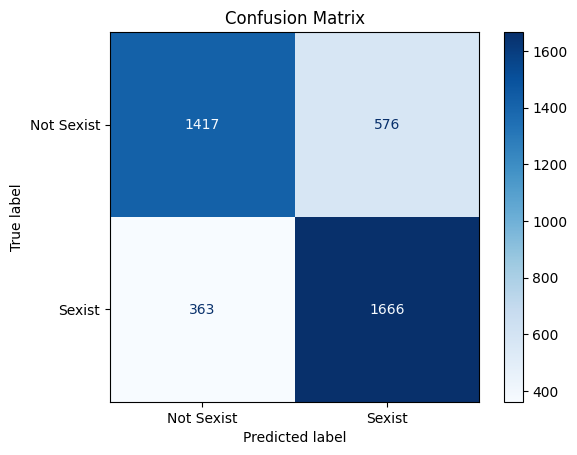

In [114]:
mean_pooling_report = classification_report(all_labels, all_predictions, output_dict=True)
print(mean_pooling_report)

cm_mean = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=['Not Sexist', 'Sexist'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [115]:
# train the model using max pooling embeddings
train_dataset = TrigramDataset(X_train_embeddings_max, y_train.tolist())
val_dataset = TrigramDataset(X_val_embeddings_max, y_val.tolist())
test_dataset = TrigramDataset(X_test_embeddings_max, y_test.tolist())

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_dim = len(X_train_embeddings[0])
model = BinaryClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

epochs = 50
for epoch in range(epochs):
    model.train()
    for embeddings, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for embeddings, labels in val_loader:
            outputs = model(embeddings)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/total:.4f}")

model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for embeddings, labels in test_loader:
        outputs = model(embeddings)
        predicted = (outputs > 0.5).float()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Epoch 1, Validation Loss: 0.6822, Accuracy: 0.5671
Epoch 2, Validation Loss: 0.6354, Accuracy: 0.6934
Epoch 3, Validation Loss: 0.5892, Accuracy: 0.7043
Epoch 4, Validation Loss: 0.5537, Accuracy: 0.7260
Epoch 5, Validation Loss: 0.5384, Accuracy: 0.7297
Epoch 6, Validation Loss: 0.5294, Accuracy: 0.7369
Epoch 7, Validation Loss: 0.5471, Accuracy: 0.7183
Epoch 8, Validation Loss: 0.5638, Accuracy: 0.7059
Epoch 9, Validation Loss: 0.5226, Accuracy: 0.7245
Epoch 10, Validation Loss: 0.5177, Accuracy: 0.7395
Epoch 11, Validation Loss: 0.5289, Accuracy: 0.7302
Epoch 12, Validation Loss: 0.5287, Accuracy: 0.7323
Epoch 13, Validation Loss: 0.5150, Accuracy: 0.7416
Epoch 14, Validation Loss: 0.5169, Accuracy: 0.7457
Epoch 15, Validation Loss: 0.5185, Accuracy: 0.7421
Epoch 16, Validation Loss: 0.5188, Accuracy: 0.7400
Epoch 17, Validation Loss: 0.5140, Accuracy: 0.7452
Epoch 18, Validation Loss: 0.5164, Accuracy: 0.7421
Epoch 19, Validation Loss: 0.5274, Accuracy: 0.7271
Epoch 20, Validation 

{'0.0': {'precision': 0.7258064516129032, 'recall': 0.767686904164576, 'f1-score': 0.7461594732991953, 'support': 1993.0}, '1.0': {'precision': 0.758098223615465, 'recall': 0.7151306062099556, 'f1-score': 0.7359878265280243, 'support': 2029.0}, 'accuracy': 0.7411735454997513, 'macro avg': {'precision': 0.7419523376141841, 'recall': 0.7414087551872658, 'f1-score': 0.7410736499136098, 'support': 4022.0}, 'weighted avg': {'precision': 0.7420968557385117, 'recall': 0.7411735454997513, 'f1-score': 0.7410281278743553, 'support': 4022.0}}


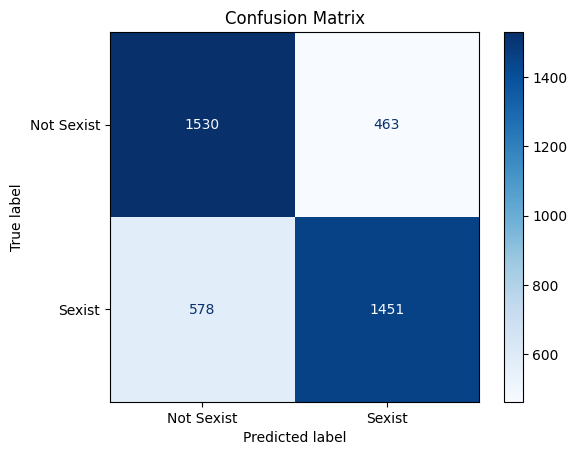

In [116]:
max_pooling_report = classification_report(all_labels, all_predictions, output_dict=True)
print(max_pooling_report)

cm_max = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_max, display_labels=['Not Sexist', 'Sexist'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [117]:
report_1_df = DataFrame(mean_pooling_report).transpose()
report_2_df = DataFrame(max_pooling_report).transpose()

# combine the two reports side by side
combined_reports = report_1_df.join(report_2_df, lsuffix='_mean_pooling', rsuffix='_max_pooling')
combined_reports

,precision_mean_pooling,recall_mean_pooling,f1-score_mean_pooling,support_mean_pooling,precision_max_pooling,recall_max_pooling,f1-score_max_pooling,support_max_pooling
0.0,0.796067,0.710988,0.751126,1993.000000,0.725806,0.767687,0.746159,1993.000000
1.0,0.743087,0.821094,0.780145,2029.000000,0.758098,0.715131,0.735988,2029.000000
accuracy,0.766534,0.766534,0.766534,0.766534,0.741174,0.741174,0.741174,0.741174
macro avg,0.769577,0.766041,0.765636,4022.000000,0.741952,0.741409,0.741074,4022.000000
weighted avg,0.769340,0.766534,0.765766,4022.000000,0.742097,0.741174,0.741028,4022.000000


## Conclusions and results

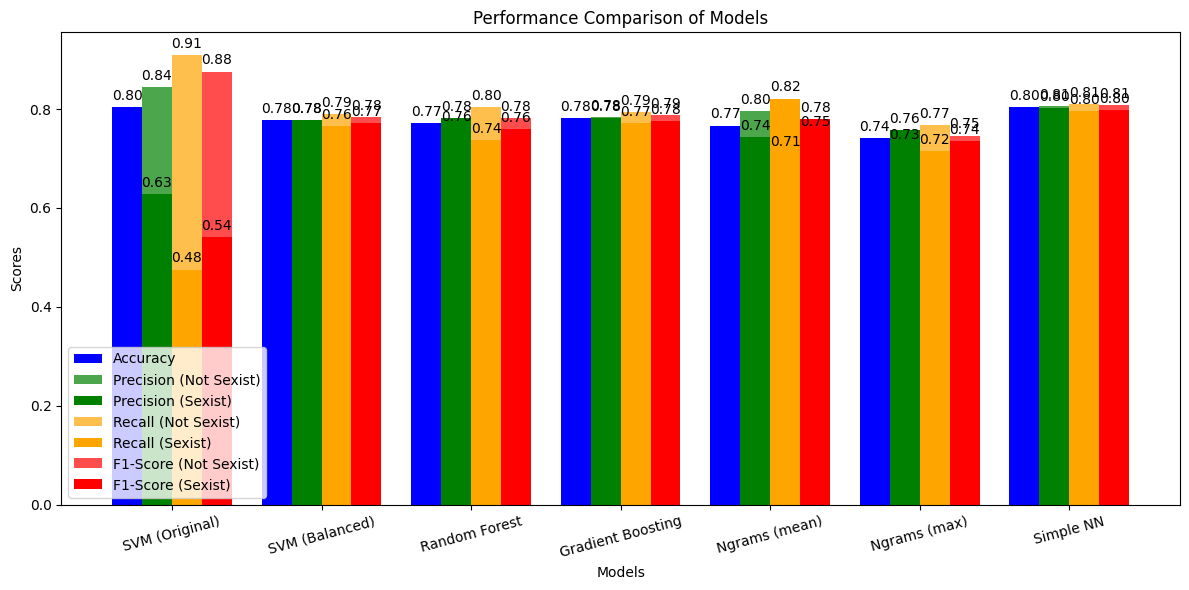

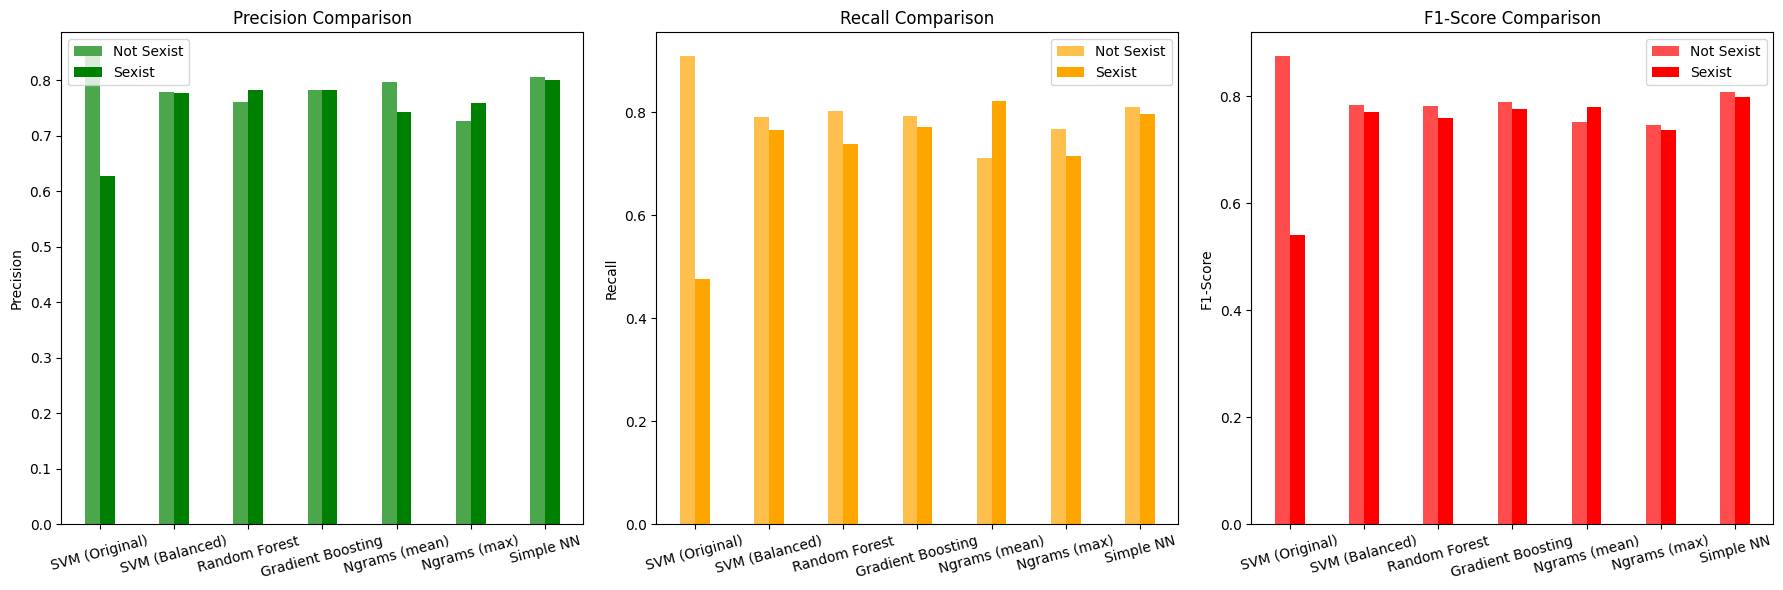

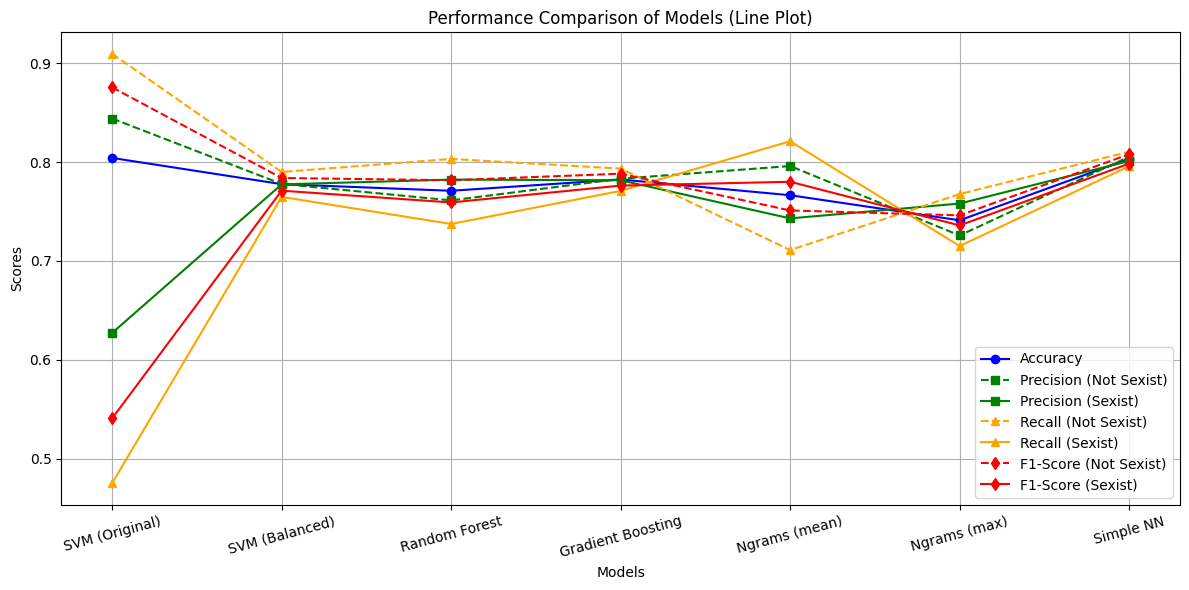

In [121]:
import numpy as np

import matplotlib.pyplot as plt

# model names and their corresponding metrics
models = ['SVM (Original)', 'SVM (Balanced)', 'Random Forest', 'Gradient Boosting', 'Ngrams (mean)', 'Ngrams (max)', 'Simple NN']

# extract precision, recall, and f1-score for each label
accuracies = [
    clf_report['accuracy'], clf_bal_report['accuracy'],
    rand_forest_report['accuracy'], grad_boost_report['accuracy'],
    mean_pooling_report['accuracy'], max_pooling_report['accuracy'],
    simple_nn_report['accuracy']
]
precisions = [
    (clf_report['Not Sexist']['precision'], clf_report['Sexist']['precision']),
    (clf_bal_report['Not Sexist']['precision'], clf_bal_report['Sexist']['precision']),
    (rand_forest_report['Not Sexist']['precision'], rand_forest_report['Sexist']['precision']),
    (grad_boost_report['Not Sexist']['precision'], grad_boost_report['Sexist']['precision']),
    (mean_pooling_report['0.0']['precision'], mean_pooling_report['1.0']['precision']),
    (max_pooling_report['0.0']['precision'], max_pooling_report['1.0']['precision']),
    (simple_nn_report['Not sexist']['precision'], simple_nn_report['Sexist']['precision'])
]
recalls = [
    (clf_report['Not Sexist']['recall'], clf_report['Sexist']['recall']),
    (clf_bal_report['Not Sexist']['recall'], clf_bal_report['Sexist']['recall']),
    (rand_forest_report['Not Sexist']['recall'], rand_forest_report['Sexist']['recall']),
    (grad_boost_report['Not Sexist']['recall'], grad_boost_report['Sexist']['recall']),
    (mean_pooling_report['0.0']['recall'], mean_pooling_report['1.0']['recall']),
    (max_pooling_report['0.0']['recall'], max_pooling_report['1.0']['recall']),
    (simple_nn_report['Not sexist']['recall'], simple_nn_report['Sexist']['recall'])
]
f1_scores = [
    (clf_report['Not Sexist']['f1-score'], clf_report['Sexist']['f1-score']),
    (clf_bal_report['Not Sexist']['f1-score'], clf_bal_report['Sexist']['f1-score']),
    (rand_forest_report['Not Sexist']['f1-score'], rand_forest_report['Sexist']['f1-score']),
    (grad_boost_report['Not Sexist']['f1-score'], grad_boost_report['Sexist']['f1-score']),
    (mean_pooling_report['0.0']['f1-score'], mean_pooling_report['1.0']['f1-score']),
    (max_pooling_report['0.0']['f1-score'], max_pooling_report['1.0']['f1-score']),
    (simple_nn_report['Not sexist']['f1-score'], simple_nn_report['Sexist']['f1-score'])
]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# accuracy
bars1 = ax.bar(x - 1.5 * width, accuracies, width, label='Accuracy', color='blue')

# precision for both classes
bars2 = ax.bar(x - 0.5 * width, [p[0] for p in precisions], width, label='Precision (Not Sexist)', color='green', alpha=0.7)
bars3 = ax.bar(x - 0.5 * width, [p[1] for p in precisions], width, label='Precision (Sexist)', color='green')

# recall for both classes
bars4 = ax.bar(x + 0.5 * width, [r[0] for r in recalls], width, label='Recall (Not Sexist)', color='orange', alpha=0.7)
bars5 = ax.bar(x + 0.5 * width, [r[1] for r in recalls], width, label='Recall (Sexist)', color='orange')

# f1-score for both classes
bars6 = ax.bar(x + 1.5 * width, [f[0] for f in f1_scores], width, label='F1-Score (Not Sexist)', color='red', alpha=0.7)
bars7 = ax.bar(x + 1.5 * width, [f[1] for f in f1_scores], width, label='F1-Score (Sexist)', color='red')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

for bars in [bars1, bars2, bars3, bars4, bars5, bars6, bars7]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# precision plot
axes[0].bar(x - width / 2, [p[0] for p in precisions], width, label='Not Sexist', color='green', alpha=0.7)
axes[0].bar(x + width / 2, [p[1] for p in precisions], width, label='Sexist', color='green')
axes[0].set_title('Precision Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15)
axes[0].set_ylabel('Precision')
axes[0].legend()

# recall plot
axes[1].bar(x - width / 2, [r[0] for r in recalls], width, label='Not Sexist', color='orange', alpha=0.7)
axes[1].bar(x + width / 2, [r[1] for r in recalls], width, label='Sexist', color='orange')
axes[1].set_title('Recall Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=15)
axes[1].set_ylabel('Recall')
axes[1].legend()

# f1-score plot
axes[2].bar(x - width / 2, [f[0] for f in f1_scores], width, label='Not Sexist', color='red', alpha=0.7)
axes[2].bar(x + width / 2, [f[1] for f in f1_scores], width, label='Sexist', color='red')
axes[2].set_title('F1-Score Comparison')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=15)
axes[2].set_ylabel('F1-Score')
axes[2].legend()

plt.tight_layout()
plt.show()

# plot the metrics using lines with different markers
fig, ax = plt.subplots(figsize=(12, 6))

# accuracy
ax.plot(models, accuracies, label='Accuracy', marker='o', linestyle='-', color='blue')

# precision for both classes
ax.plot(models, [p[0] for p in precisions], label='Precision (Not Sexist)', marker='s', linestyle='--', color='green')
ax.plot(models, [p[1] for p in precisions], label='Precision (Sexist)', marker='s', linestyle='-', color='green')

# recall for both classes
ax.plot(models, [r[0] for r in recalls], label='Recall (Not Sexist)', marker='^', linestyle='--', color='orange')
ax.plot(models, [r[1] for r in recalls], label='Recall (Sexist)', marker='^', linestyle='-', color='orange')

# f1-score for both classes
ax.plot(models, [f[0] for f in f1_scores], label='F1-Score (Not Sexist)', marker='d', linestyle='--', color='red')
ax.plot(models, [f[1] for f in f1_scores], label='F1-Score (Sexist)', marker='d', linestyle='-', color='red')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Models (Line Plot)')
ax.legend()
ax.grid(True)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

These final plots hints to the impovement of models trained on the balanced dataset with respect to the original one, that showed non-linearity.